In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pprint import pprint
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

plt.rcParams["figure.figsize"] = (16, 10)

# Reading reports from file

In [2]:
who_daily_reports_dir_name = "who_daily_reports"

In [3]:
column_names = ['Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']
new_column_names = ['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Recovered']

reports_files_names = sorted(os.listdir(who_daily_reports_dir_name))
reports = []
for report_file_name in reports_files_names:
    date = datetime.strptime(report_file_name[:-4], '%m-%d-%Y')
    dataframe = pd.read_csv(os.path.join(who_daily_reports_dir_name, report_file_name))
    
    try:
        dataframe = dataframe[column_names]
    except KeyError:
        dataframe = dataframe[new_column_names]
        dataframe = dataframe.rename(columns={'Province_State': 'Province/State', 'Country_Region': 'Country/Region'})
    
    dataframe['Province/State'].fillna("NotSpecified", inplace=True)
    dataframe.fillna(0, inplace=True)

    dataframe = dataframe.astype({'Confirmed': 'int32', 'Deaths': 'int32', 'Recovered': 'int32'}, copy=False)
    
    reports.append((date, dataframe))
    
reports = np.array(reports)

In [4]:
reports[-1, 1].head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,South Carolina,United States,24,0,0
1,Louisiana,United States,129,7,0
2,Virginia,United States,100,3,0
3,Idaho,United States,642,14,0
4,Iowa,United States,1,0,0


# Getting all countries from the reports

In [5]:
def get_all_countries():
    countries = []
    for report in reports[:, 1]:
        column_values = report[["Country/Region"]].values
        countries += np.unique(column_values).tolist()
    return np.unique(countries)
    
countries = get_all_countries()

# Getting characteristic for all countries

In [6]:
CONFIRMED = "Confirmed"
DEATHS = "Deaths"
RECOVERED = "Recovered"

countres_characteristic  = {}
for country in countries:
    countres_characteristic[country] = {CONFIRMED:[], DEATHS:[], RECOVERED: []}

for report in reports[:, 1]:
    region_aggregated_stats = report.groupby('Country/Region').sum()
    for index, row in region_aggregated_stats.iterrows():
        countres_characteristic[index][CONFIRMED].append(row[CONFIRMED])
        countres_characteristic[index][DEATHS].append(row[DEATHS])
        countres_characteristic[index][RECOVERED].append(row[RECOVERED])

# pprint(countres_characteristic)

# Filtering countries which meet the constraints

1. The epidemy starts when there are epidemy_start_cases_number number of cases.
2. Epidemy lasts for at least day_range days.

In [7]:
countries_with_enough_data = {}

epidemy_start_cases_number = 20
day_range = 40

for country, data in countres_characteristic.items():
    confirmed = [i for i in data[CONFIRMED] if i >= epidemy_start_cases_number]
    epidemy_days = len(confirmed)
    if  epidemy_days < day_range:
        continue
    confirmed = confirmed[:day_range]
    deaths = data[DEATHS][-epidemy_days:]
    deaths = deaths[:day_range]
    recovered = data[RECOVERED][-epidemy_days:]
    recovered = recovered[:day_range]
    countries_with_enough_data[country] = {CONFIRMED : confirmed, DEATHS : deaths, RECOVERED : recovered}
#     print(len(confirmed), len(deaths), len(recovered))

# Creating countries characteristics vector

In [8]:
vectors = []
countries = []
for country, data in countries_with_enough_data.items():
    vector = []
    for day in range (1,day_range):
        vector.append((data[CONFIRMED][day] - data[CONFIRMED][day - 1])/ data[CONFIRMED][day - 1])
    for day in range (1,day_range):
        if(data[DEATHS][day - 1] == 0):
            vector.append(0)
        else:
            vector.append((data[DEATHS][day] - data[DEATHS][day - 1])/ data[DEATHS][day - 1])
    for day in range (1,day_range):
        if(data[RECOVERED][day - 1] == 0):
            vector.append(0)
        else:
            vector.append((data[RECOVERED][day] - data[RECOVERED][day - 1])/ data[RECOVERED][day - 1])
    vectors.append(vector)
    countries.append(country)
vectors = np.array(vectors)
vectors.shape

(84, 117)

# Clustering

/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


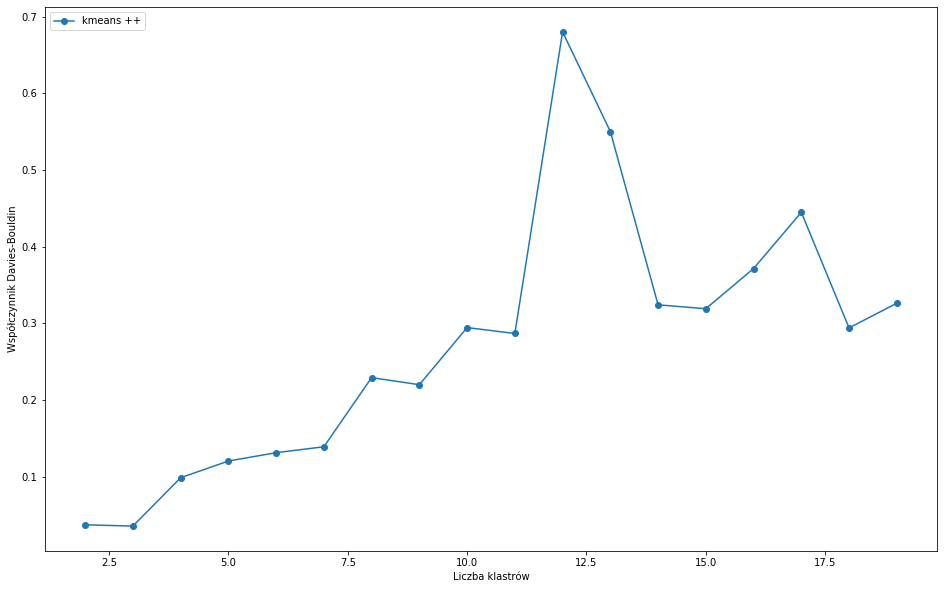

In [9]:
def get_score(ds,clusters):
    kmeans = KMeans(n_clusters=clusters, n_init = 5).fit(ds)
    labels = kmeans.labels_
    return davies_bouldin_score(ds, labels)

def get_score_for_number_of_clusters(ds):
    results = []
    for clusters in range(2, 20):
        results.append(get_score(ds, clusters))
    return results


def visualize_score_graph_number_of_clusters(ds):
    results = get_score_for_number_of_clusters(ds)
    ax = plt.plot(range(2, 20), results, marker='o',label="kmeans ++")
    ax = plt.axes()
    ax.set_xlabel("Liczba klastrów")
    ax.set_ylabel("Współczynnik Davies-Bouldin")
    ax.legend(loc='upper left', numpoints=1)
    plt.show()
    
visualize_score_graph_number_of_clusters(vectors)
    

# Visualization 

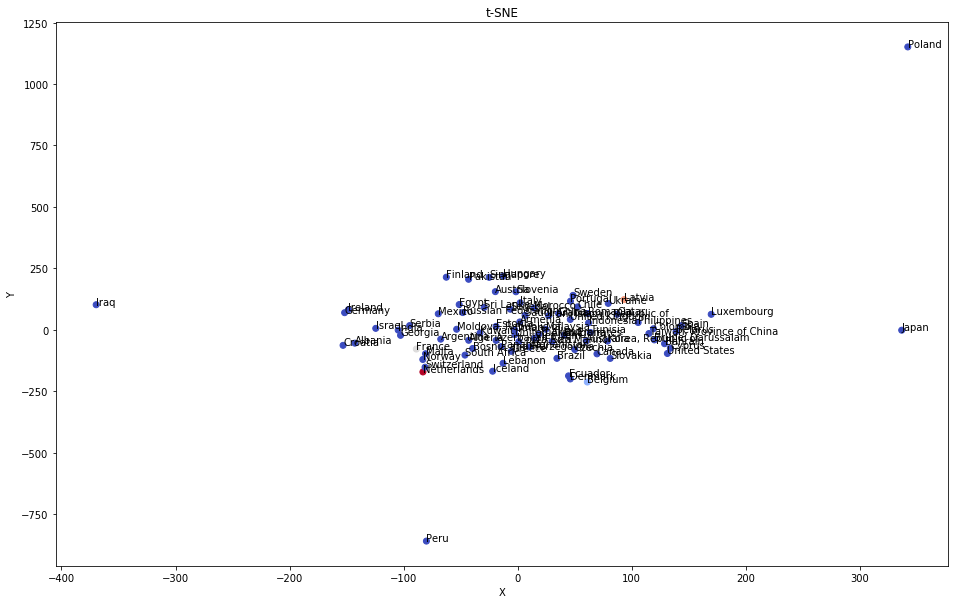

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric='euclidean', perplexity=7).fit_transform(vectors)

def visualize_clusetrs(colors = None):
    fig, ax = plt.subplots()
    ax.scatter(tsne[:,0], tsne[:,1], c = colors, cmap=plt.cm.coolwarm)
    for i, txt in enumerate(countries):
        ax.annotate(txt, (tsne[i][0], tsne[i][1]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title("t-SNE")
    plt.show()
    
kmeans = KMeans(n_clusters=5).fit(vectors)
labels = kmeans.labels_
visualize_clusetrs(labels)

# Adding procentage of deths to the vectors

In [11]:
vector_with_death_procentge  = []
vector_combined = []
for country, vector in zip(countries, vectors):
    death_procentage  = []
    for day in range(day_range):
        confirmed = countries_with_enough_data[country][CONFIRMED][day]
        deaths = countries_with_enough_data[country][DEATHS][day]
        death_procentage.append(deaths/confirmed)

    vector_with_death_procentge.append(death_procentage)
    vector_combined.append(np.append(vector, death_procentage))
    
vector_with_death_procentge = np.array(vector_with_death_procentge)
vector_combined = np.array(vector_combined)
print(vector_combined.shape)
print(vector_with_death_procentge.shape)

(84, 157)
(84, 40)


/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


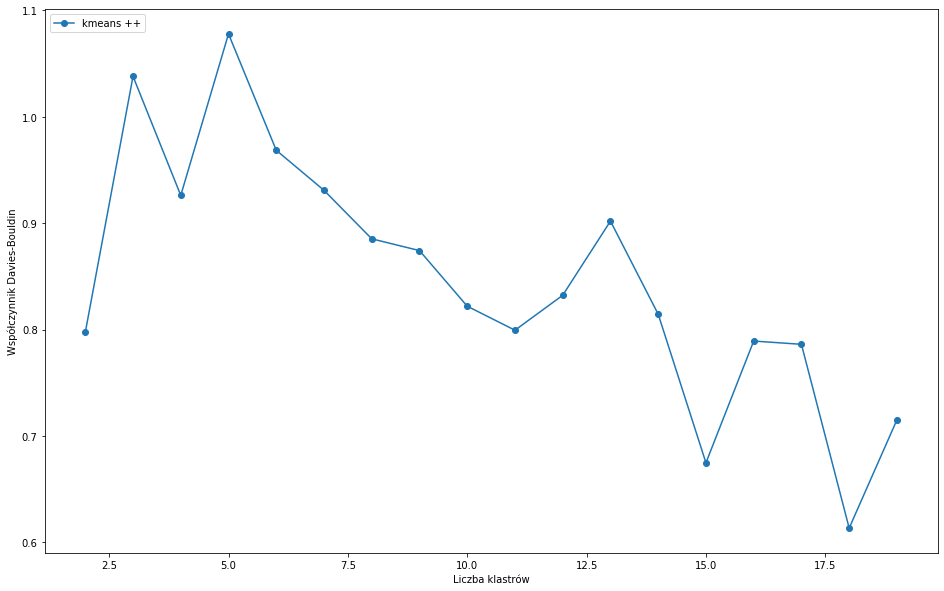

In [12]:
visualize_score_graph_number_of_clusters(vector_with_death_procentge)

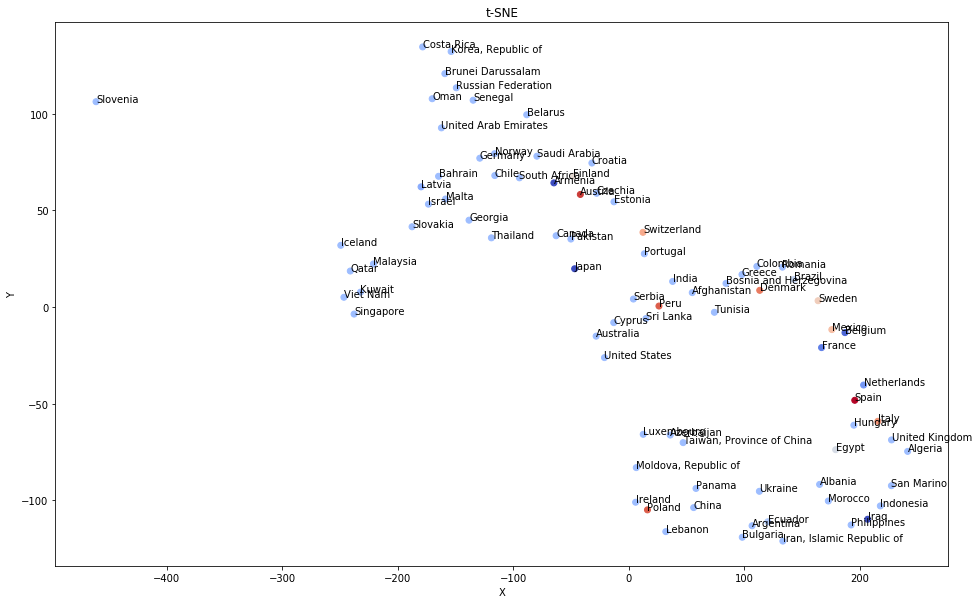

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric='euclidean', perplexity=5).fit_transform(vector_with_death_procentge)

kmeans = KMeans(n_clusters=18).fit(vectors)
labels = kmeans.labels_
visualize_clusetrs(labels)

/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


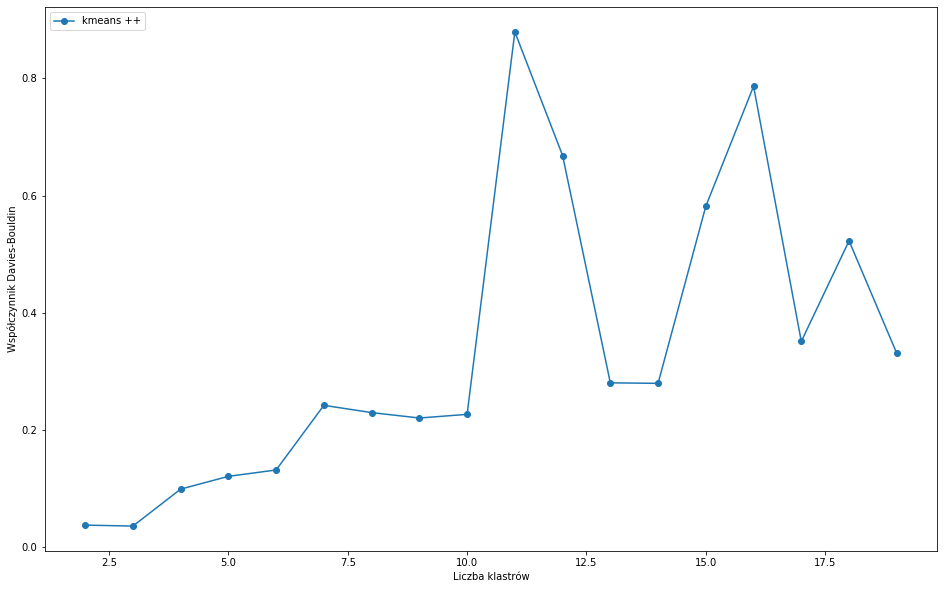

In [20]:
visualize_score_graph_number_of_clusters(vector_combined)

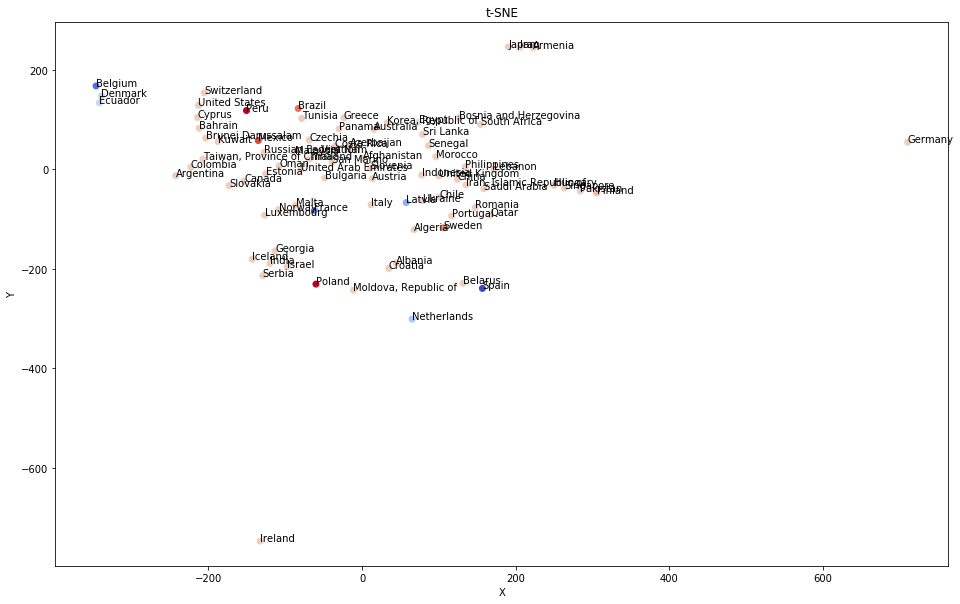

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric='euclidean', perplexity=3).fit_transform(vector_combined)

kmeans = KMeans(n_clusters=13).fit(vectors)
labels = kmeans.labels_
        
visualize_clusetrs(labels)